# Advanced EDA


In [4]:
import pandas as pd

# Read the dataset
df_weather = pd.read_csv("../data/cleaned_normalized_weather.csv")

# Display basic info
print(df_weather.shape)
print(df_weather.info())
df_weather.head()


(33346, 41)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33346 entries, 0 to 33345
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       33346 non-null  int64  
 1   location_name                 33346 non-null  int64  
 2   latitude                      33346 non-null  float64
 3   longitude                     33346 non-null  float64
 4   timezone                      33346 non-null  int64  
 5   last_updated_epoch            33346 non-null  float64
 6   last_updated                  33346 non-null  object 
 7   temperature_celsius           33346 non-null  float64
 8   temperature_fahrenheit        33346 non-null  float64
 9   condition_text                33346 non-null  int64  
 10  wind_mph                      33346 non-null  float64
 11  wind_kph                      33346 non-null  float64
 12  wind_degree                   33346 non-null  fl

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,0,88,0.700737,0.709545,98,0.0,2024-05-16 13:15:00,0.583113,0.581498,12,...,0.225555,0.457367,0.0,0.0,100,174,1345,22,7,0.55
1,5,168,0.524997,0.127417,44,0.0,2024-05-16 04:45:00,0.567282,0.566814,13,...,0.023314,0.072014,0.0,0.0,146,156,11,28,7,0.55
2,6,52,0.002727,0.141545,45,0.0,2024-05-16 05:45:00,0.092348,0.091043,0,...,0.101963,0.085963,0.0,0.0,273,123,193,8,7,0.55
3,8,198,0.838905,0.474926,157,0.0,2024-05-16 10:45:00,0.303430,0.302496,13,...,0.093537,0.070270,0.0,0.0,124,273,1,204,7,0.55
4,9,26,0.760125,0.623801,84,0.0,2024-05-16 12:45:00,0.329815,0.328928,13,...,0.042976,0.031909,0.0,0.0,133,235,1429,140,7,0.55


##  Anomaly Detection in Weather Data Using Isolation Forest, LOF, and One-Class SVM

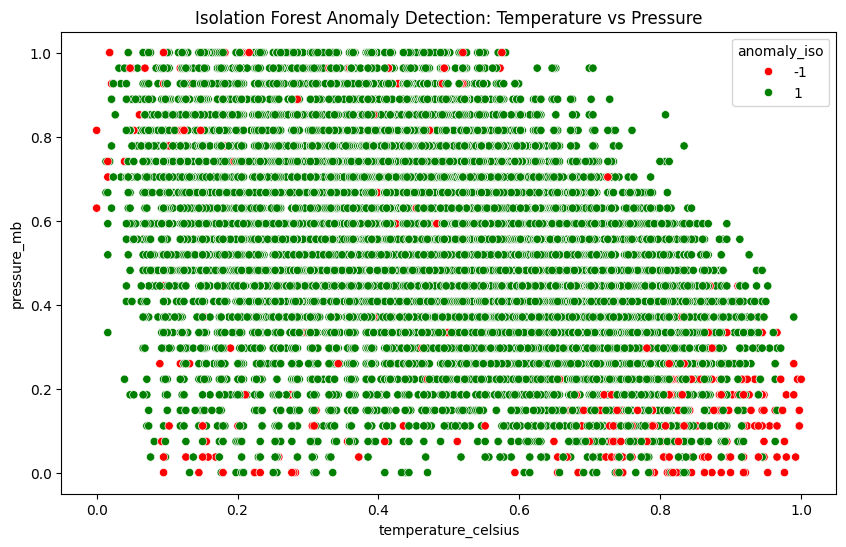

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

# Numerical Columns
features = [
    'temperature_celsius', 'wind_kph', 'pressure_mb', 'humidity', 'visibility_km',
    'gust_kph', 'air_quality_PM2.5', 'air_quality_PM10', 'air_quality_Ozone'
]

df_anomaly = df_weather[features].copy()

# Isolation Forest (Global Outlier Detection)
iso_forest = IsolationForest(contamination=0.02, random_state=42)
df_anomaly['anomaly_iso'] = iso_forest.fit_predict(df_anomaly[features])

# Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
df_anomaly['anomaly_lof'] = lof.fit_predict(df_anomaly[features])

# One-Class SVM 
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.02)
df_anomaly['anomaly_svm'] = svm.fit_predict(df_anomaly[features])

# Visualize Anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_anomaly,
    x='temperature_celsius',
    y='pressure_mb',
    hue='anomaly_iso',
    palette={1: 'green', -1: 'red'}
)
plt.title('Isolation Forest Anomaly Detection: Temperature vs Pressure')
plt.show()





In [6]:
# Compare Detection Methods
print("Isolation Forest anomalies:", (df_anomaly['anomaly_iso'] == -1).sum())
print("Local Outlier Factor anomalies:", (df_anomaly['anomaly_lof'] == -1).sum())
print("One-Class SVM anomalies:", (df_anomaly['anomaly_svm'] == -1).sum())


Isolation Forest anomalies: 667
Local Outlier Factor anomalies: 667
One-Class SVM anomalies: 666


In [8]:
# Correlate Anomalies with Weather Events
anomalous_records = df_weather.loc[df_anomaly['anomaly_iso'] == -1, ['country', 'location_name', 'condition_text', 'temperature_celsius', 'pressure_mb']]
display(anomalous_records.head(10))


,country,location_name,condition_text,temperature_celsius,pressure_mb
52,105,146,18,0.870712,0.185185
257,40,136,18,0.620053,0.444444
350,54,8,13,0.461741,0.814815
357,74,25,18,0.883905,0.185185
436,74,25,13,0.910290,0.148148
569,36,172,13,0.514512,0.703704
588,92,17,9,0.197889,0.962963
609,14,2,13,0.329815,0.296296
652,74,25,13,0.910290,0.148148
653,75,72,13,0.224274,0.592593


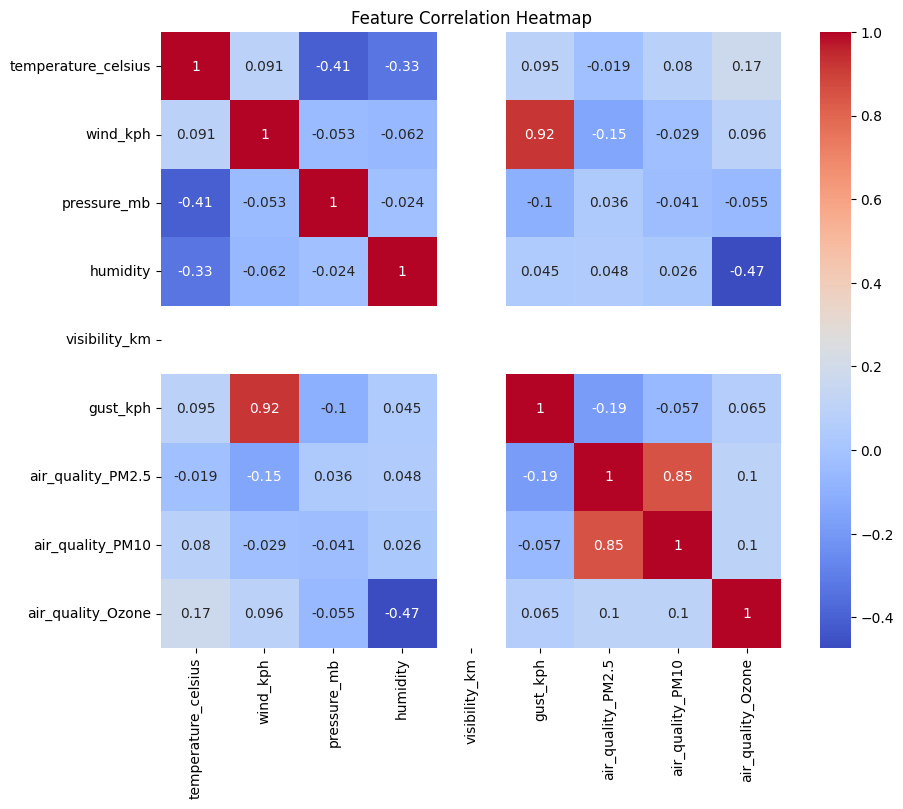

In [9]:
# Visualize Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_weather[features].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


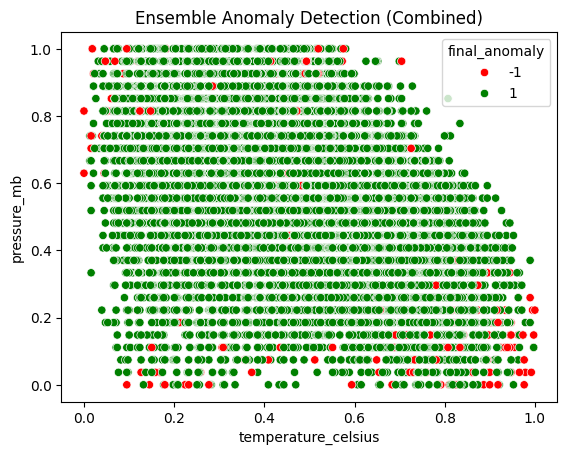

In [10]:
import numpy as np

df_anomaly['combined_anomaly'] = (
    (df_anomaly['anomaly_iso'] == -1).astype(int) +
    (df_anomaly['anomaly_lof'] == -1).astype(int) +
    (df_anomaly['anomaly_svm'] == -1).astype(int)
)

# Points detected by at least 2 methods = strong anomalies
df_anomaly['final_anomaly'] = np.where(df_anomaly['combined_anomaly'] >= 2, -1, 1)

sns.scatterplot(
    data=df_anomaly,
    x='temperature_celsius',
    y='pressure_mb',
    hue='final_anomaly',
    palette={1: 'green', -1: 'red'}
)
plt.title('Ensemble Anomaly Detection (Combined)')
plt.show()
